In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.linear_model import LinearRegression
from matplotlib.dates import DateFormatter, YearLocator
import tensorflow.keras.regularizers as regularizers

# 데이터 다운로드 및 전처리
def download_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df[['Close', 'Volume']]
    df.reset_index(inplace=True)
    return df

# 시계열 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# TimesNet 모델 구현
class TimeSeriesTransform(layers.Layer):
    def __init__(self, d_model, num_harmonics=64):
        super(TimeSeriesTransform, self).__init__()
        self.num_harmonics = num_harmonics
        self.dense = layers.Dense(d_model)

    def call(self, inputs):
        freq_data = tf.signal.rfft(inputs)
        freq_data = tf.concat([tf.math.real(freq_data), tf.math.imag(freq_data)], axis=-1)
        freq_data = freq_data[:, :, :self.num_harmonics]
        return self.dense(freq_data)

class TimeSeriesBlock(Model):
    def __init__(self, d_model, num_harmonics, dropout_rate=0.1, l2_lambda=0.001):
        super(TimeSeriesBlock, self).__init__()
        self.time_transform = TimeSeriesTransform(d_model, num_harmonics)
        self.multihead_attn = layers.MultiHeadAttention(num_heads=8, key_dim=d_model)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(4 * d_model, activation='relu', 
                         kernel_regularizer=regularizers.l2(l2_lambda)),  # L2 정규화 추가
            layers.Dense(d_model, kernel_regularizer=regularizers.l2(l2_lambda)),  # L2 정규화 추가
            layers.Dropout(dropout_rate)  # 드롭아웃 추가
        ])

    def call(self, x, training=False):
        x = self.time_transform(x)
        attn_output = self.multihead_attn(x, x)
        out1 = self.norm1(x + attn_output)
        ffn_output = self.ffn(out1, training=training)
        return self.norm2(out1 + ffn_output)

class TimesNet(Model):
    def __init__(self, input_dim, d_model, num_layers, num_harmonics, output_dim):
        super(TimesNet, self).__init__()
        self.input_proj = layers.Dense(d_model)
        self.blocks = [TimeSeriesBlock(d_model, num_harmonics) for _ in range(num_layers)]
        self.output_proj = layers.Dense(output_dim)

    def call(self, x, training=False):
        x = self.input_proj(x)
        for block in self.blocks:
            x = block(x, training=training)
        return self.output_proj(x[:, -1, :])

# 데이터 정사영 함수 정의
def detrend_data(data):
    X = np.arange(len(data)).reshape(-1, 1)
    y = data['Close'].values
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    detrended_data = data.copy()
    detrended_data['Close'] = y - trend
    return detrended_data, trend

# 정사영된 데이터의 예측 결과를 원래 값으로 복원하는 함수 정의
def restore_trend(pred, trend):
    return pred + trend[-len(pred):]

# 실시간 시각화 콜백 정의
class RealTimePlot(tf.keras.callbacks.Callback):
    def __init__(self, model, X_test, y_test, scaler, dates, trend, save_dir='plots'):
        super(RealTimePlot, self).__init__()
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.scaler = scaler
        self.dates = dates[-len(y_test):]  # 테스트 데이터에 해당하는 날짜만 사용
        self.trend = trend[-len(y_test):]  # 테스트 데이터에 해당하는 트렌드만 사용
        self.save_dir = save_dir
        self.actual = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0]  # 실제 값 초기화
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        plt.figure(figsize=(14, 7))
        
        pred = self.model.predict(self.X_test)
        self.predicted = self.scaler.inverse_transform(np.c_[pred, np.zeros_like(pred)])[:, 0]
        restored_pred = restore_trend(self.predicted, self.trend)
        restored_actual = restore_trend(self.actual, self.trend)

        plt.plot(self.dates, restored_actual, label='Actual Price', color='blue')
        plt.plot(self.dates, restored_pred, label=f'Predicted Price (Epoch {epoch+1})', color='red')
        
        plt.title(f'TimesNet Prediction vs Actual on Test Data (Epoch {epoch+1})', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)

        # X축을 날짜 형식으로 표시하고 1년 단위로 구분
        plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
        plt.gca().xaxis.set_major_locator(YearLocator())
        plt.gca().tick_params(axis='both', which='major', labelsize=10)

        # 각 연도별로 세로선 추가
        for year in YearLocator().tick_values(self.dates.min(), self.dates.max()):
            plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5)
            
        # 적절한 간격으로 가로선 하나만 추가 (가장 중앙에 위치)
        min_price = min(restored_actual.min(), restored_pred.min())
        max_price = max(restored_actual.max(), restored_pred.max())
        middle_price = (min_price + max_price) / 2  # 중간값 계산

        plt.axhline(y=middle_price, color='gray', linestyle='--', linewidth=0.5)
        
        plt.legend(fontsize=10)
        plt.grid(True)

        # 차트를 파일로 저장하기 전에 그리기 버퍼를 비웁니다.
        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch+1}.png'))
        
                # 차트를 화면에 표시
        plt.show()
        
        plt.close()


    def on_train_end(self, logs=None):
        plt.ioff()


# 최종 결과 확인을 위한 예측 (테스트 데이터 부분만)
def plot_final_results(dates, y_actual, y_pred):
    plt.figure(figsize=(14, 7))
    plt.plot(dates[-len(y_actual):], y_actual, label='Actual Price', color='blue')
    plt.plot(dates[-len(y_pred):], y_pred, label='Predicted Price', color='red')

    # X축을 날짜 형식으로 표시하고 1년 단위로 구분
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(YearLocator())

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('TimesNet Prediction vs Actual on Test Data')
    plt.legend()
    plt.grid(True)

    plt.show()

# 데이터 다운로드 및 전처리
ticker = 'QQQ'
start_date = '2000-01-01'
end_date = '2024-01-01'

data = download_stock_data(ticker, start_date, end_date)
dates = data['Date']

# 데이터 선형회귀를 통한 정사영
detrended_data, trend = detrend_data(data)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
detrended_data[['Close', 'Volume']] = scaler.fit_transform(detrended_data[['Close', 'Volume']])

# 시퀀스 데이터 생성
seq_length = 5
X, y = create_sequences(detrended_data[['Close', 'Volume']].values, seq_length)

# 데이터 분할
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# TensorFlow 텐서로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# 모델 초기화 및 컴파일
input_dim = X_train.shape[-1]
d_model = 64
num_layers = 3
num_harmonics = 16
output_dim = 1
dropout_rate = 0.1  # 드롭아웃 비율 설정
l2_lambda = 0.001  # L2 정규화 강도 설정

model = TimesNet(input_dim, d_model, num_layers, num_harmonics, output_dim)
for layer in model.blocks:
    layer.ffn.add(layers.Dropout(dropout_rate))
    layer.ffn.add(layers.Dense(d_model, kernel_regularizer=regularizers.l2(l2_lambda)))

model.compile(optimizer='adam', loss='mse')

# 실시간 시각화 콜백 인스턴스 생성
real_time_plot = RealTimePlot(model, X_test, y_test, scaler, dates, trend, save_dir='plots')

# 모델 학습
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[real_time_plot])

# 최종 결과 확인을 위한 예측 (테스트 데이터 부분만)
y_pred_scaled = model.predict(X_test)
y_pred_detrended = scaler.inverse_transform(np.c_[y_pred_scaled, np.zeros_like(y_pred_scaled)])[:, 0]
y_pred = restore_trend(y_pred_detrended, trend[-len(y_pred_detrended):])

# 테스트 데이터의 실제값 복원
y_test_detrended = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0]
y_actual = restore_trend(y_test_detrended, trend[-len(y_test_detrended):])

# 최종 결과 시각화
plot_final_results(dates, y_actual, y_pred)



In [20]:
model.summary()

Model: "times_net_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           multiple                  192       
                                                                 
 time_series_block_33 (TimeS  multiple                 171264    
 eriesBlock)                                                     
                                                                 
 time_series_block_34 (TimeS  multiple                 171264    
 eriesBlock)                                                     
                                                                 
 time_series_block_35 (TimeS  multiple                 171264    
 eriesBlock)                                                     
                                                                 
 dense_131 (Dense)           multiple                  65        
                                                      

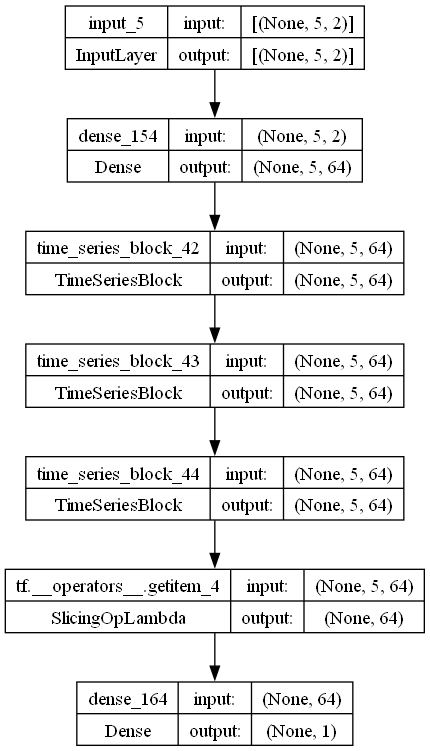

In [ ]:


from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input

# 모델 초기화 및 컴파일
input_dim = X_train.shape[-1]  # 특성 수에 맞춤
d_model = 64
num_layers = 3
num_harmonics = 16
output_dim = 1

# 명시적으로 입력 정의
inputs = Input(shape=(seq_length, input_dim))

# TimesNet 모델 레이어 정의
x = layers.Dense(d_model)(inputs)
for _ in range(num_layers):
    x = TimeSeriesBlock(d_model, num_harmonics)(x)
outputs = layers.Dense(output_dim)(x[:, -1, :])

# 모델 정의
model = Model(inputs, outputs)

# 모델 빌드
model.build(input_shape=(None, seq_length, input_dim))

# 모델 구조 시각화 (세부 정보 포함)
plot_model(model, "detailed_timesnet_model.png", show_shapes=True, show_layer_names=True, expand_nested=True)


model.summary()

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 67ms/step
Date: 2024-01-02, Predicted Price: 413.53, Actual Price: 402.59
Date: 2024-01-03, Predicted Price: 411.24, Actual Price: 398.33
Date: 2024-01-04, Predicted Price: 408.77, Actual Price: 396.28
Date: 2024-01-05, Predicted Price: 406.26, Actual Price: 396.75
Date: 2024-01-08, Predicted Price: 404.17, Actual Price: 404.95
Date: 2024-01-09, Predicted Price: 403.52, Actual Price: 405.75
Date: 2024-01-10, Predicted Price: 403.81, Actual Price: 408.50
Date: 2024-01-11, Predicted Price: 405.61, Actual Price: 409.35
Date: 2024-01-12, Predicted Price: 408.32, Actual Price: 409.56
Date: 2024-01-16, Predicted Price: 411.19, Actual Price: 409.52
Date: 2024-01-17, Predicted Price: 412.09, Actual Price: 407.21
Date: 2024-01-18, Predicted Price: 412.20, Actual Price: 412.99
Date: 2024-01-19, Predicted Price: 413.25, Actual Price: 421.18
Date: 2024-01-22, Predicted Price: 416.40, Actual Price: 421.73
Date: 2024-01-23, Predicted Price: 418.25, Actual Pr

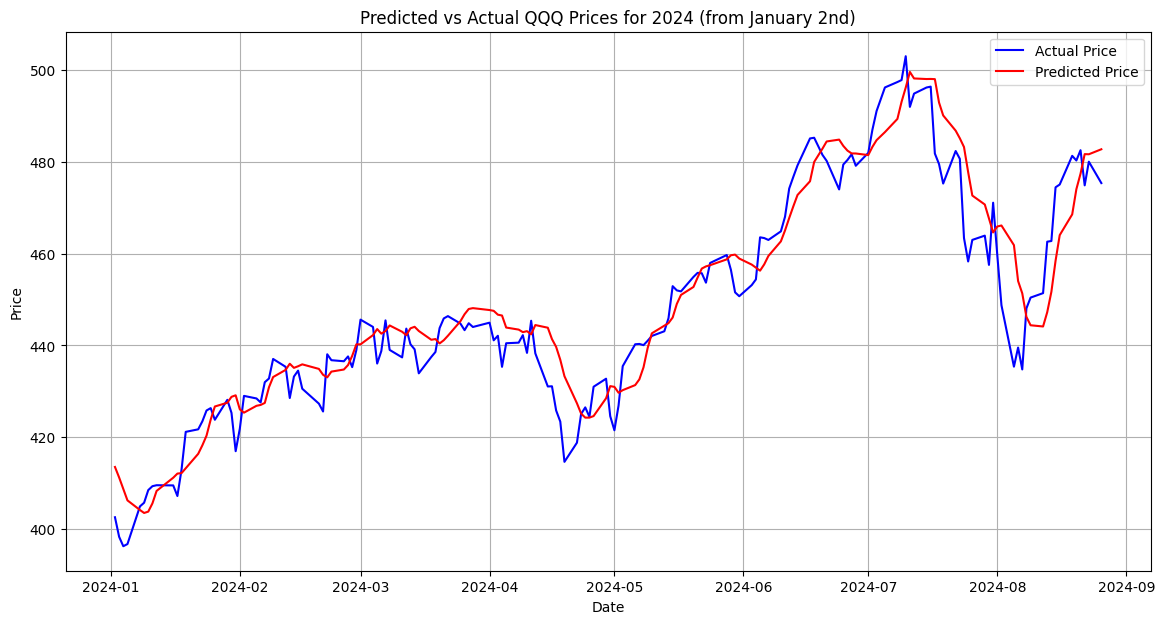

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 다운로드 및 전처리
ticker = 'QQQ'
start_date = '2023-12-18'
end_date = '2024-08-27'

# 2024년 데이터를 다운로드
future_data = download_stock_data(ticker, start_date, end_date)
future_dates = future_data['Date']

# 데이터를 정사영
future_detrended_data, future_trend = detrend_data(future_data)

# 데이터 정규화 (학습 시 사용한 scaler를 재사용)
future_detrended_data[['Close', 'Volume']] = scaler.transform(future_detrended_data[['Close', 'Volume']])

# 2024년 데이터를 예측하는 부분
predictions = []
actuals = []

# 시퀀스 초기화 (이전 학습 데이터의 마지막 시퀀스를 사용)
sequence = detrended_data[['Close', 'Volume']].values[-seq_length:]

for i in range(len(future_detrended_data)):
    # 모델 입력 데이터 생성
    sequence_tensor = tf.convert_to_tensor([sequence], dtype=tf.float32)

    # 하루 예측
    predicted_scaled = model.predict(sequence_tensor)
    
    # 예측값 역정규화 및 트렌드 복원
    predicted_detrended = scaler.inverse_transform(np.c_[predicted_scaled, np.zeros_like(predicted_scaled)])[:, 0]
    predicted_price = restore_trend(predicted_detrended, future_trend[:i+1])[-1]
    
    # 실제 값
    actual_price = future_data.iloc[i]['Close']

    # 예측 및 실제 값을 저장
    predictions.append(predicted_price)
    actuals.append(actual_price)
    
    # 시퀀스 업데이트 (가장 오래된 데이터를 버리고 새로운 예측된 데이터를 추가)
    new_data = future_detrended_data[['Close', 'Volume']].values[i]
    sequence = np.vstack([sequence[1:], new_data])

# 2024년 1월 2일 이후의 데이터 선택
start_index = future_dates[future_dates >= pd.Timestamp('2024-01-02')].index[0]
plot_dates = future_dates[start_index:]
plot_predictions = predictions[start_index:]
plot_actuals = actuals[start_index:]

# 결과 출력
for date, pred, act in zip(plot_dates, plot_predictions, plot_actuals):
    print(f"Date: {date.date()}, Predicted Price: {pred:.2f}, Actual Price: {act:.2f}")

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(plot_dates, plot_actuals, label='Actual Price', color='blue')
plt.plot(plot_dates, plot_predictions, label='Predicted Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs Actual QQQ Prices for 2024 (from January 2nd)')
plt.legend()
plt.grid(True)
plt.show()
